### Step 1: What can be changed
* remember to change the hyperparameters and optimizer in step 6

In [1]:
datapathway=r"C:\Users\wingt\Downloads\S11_along_BD_205.csv"
xstart=3            #column of xstart
xstop=5            #column of xend
ystart=6           #column of ystart
yname='Stress'      # name of the ultimate output array
yparameter='Position'       #position here but it will be what is the parameter to be tuned
xcolumn=['Travel_length', 'Welding_speed', 'Net_energy_input'] #name of inputs

### Step 2: Import library

In [2]:
import numpy as np
import pandas as pd
import warnings
import os
import random
import pickle
# import ML related libraries
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from tensorflow.keras.optimizers import SGD, Adam
from keras.models import Model
from keras.layers import Dense, Input, Dropout
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping, ModelCheckpoint
#from bayes_opt import BayesianOptimization
# import plotting related libraries
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from scipy import interpolate

### Step 3: Get Plot
It is a function plotting the actual simulation result and the prediction result

In [3]:
def get_plot(oringin_data, predict_data, i):
    '''
    Plot target outputs against predicted outputs
    inputs:
        oringin_data: target outputs
        predict_data: predicted outputs
        i: plot index
        root: root for saving figure
    '''
    root = r'ANN_results/BD/test/test--' + str(i) + '.jpg'
    fig, ax = plt.subplots(figsize=(10,6))
    x = y_label_new
    oringin_data = oringin_data 
    predict_data = predict_data 
    p1 = ax.plot(x,oringin_data.ravel(),'r--', label = 'Target stress')
    p2 = ax.plot(x,predict_data.ravel(),'g--',label = 'Predict stress')
    ax.set_title("Test-Set" + str(i))
    # ax.set_xticks(x)
    ax.set_ylabel('Logitudinal stress (MPa)')
    ax.set_xlabel('Distance from top surface Z(mm)')
    
    ax.xaxis.set_major_locator(plt.MultipleLocator(1))
    ax.yaxis.set_tick_params(direction='out')

    ax2 = plt.twinx()
    difference = predict_data.ravel() - oringin_data.ravel()
    difference=np.array(list(map(lambda x,y:x/y,difference,oringin_data.ravel())))


    legend_elements = [Line2D([0], [0], color='red', lw=2, label='Simulation result'),
                       Line2D([0], [0], color='green', lw=2, label='ANN prediction')
                      ]

    ax.legend(handles=legend_elements, loc='best')
    plt.savefig(root)
    plt.close()

### Step 4: Plot_history
plot learning curve
make learning history(generated later after building a model) a dataframe and insert a column called epoch in it
plot MSE against epoch
plot val_mse (should be validation mse) against no of epoch (validation error)

In [4]:
def plot_history(history):
    '''
    Plot learning curve using NN training history info
    '''
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    plt.figure()
    plt.xlabel('Epoch',fontsize=20)
    plt.ylabel('Mean Square Error [$MPG^2$]',fontsize=20)
    plt.plot(hist['epoch'], hist['mse'],
            label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
            label = 'Val Error')
    plt.ylim([0,0.4])
    plt.legend()
    plt.show()

### Step 5: import data + preprocessing
import the data using pd.read_csv
only get columns required
assign column names
get y data for training as well

In [5]:
def data_import(csv_file_name):
    '''
    used to import dataset and split training and test dataset
    csv_file_name is the dateset root
    reture traing and test datasets
    '''
    raw_data = pd.read_csv(csv_file_name,header=None).dropna()
    x = raw_data.iloc[:,xstart:(xstop+1)]
    #x.columns = xcolumn
    y = raw_data.iloc[:,ystart:]
    return x, y

### Step 6: function for creating a model for all tuned hyperparameter
* need to change the hyperparameters combination and optimizer here 

In [6]:
def build_model(N_hidden_nodes, input_dim, N_outputs, l_rate, Batch_size, Epochs):
    '''
    Build a NN
    inputs:
        N_hidden_nodes: number of neurons
        input_dim: number of inputs
        N_outputs: number of outputs
        l_rate: learning rate
        Batch_size: Batch size
    outputs:
        model: Trained model
        history: training history
    '''
    callbacks = [
        EarlyStopping(monitor='val_mse', patience=100, verbose=2), #no change in 100 epoch -> stop
        ModelCheckpoint('best_model.h5', monitor='val_mse', save_best_only=True, verbose=0) # only save best model in perspective of validation MSE
    ]
    model = keras.Sequential([
        keras.layers.Dense(N_hidden_nodes, activation=tf.nn.leaky_relu, input_shape=(input_dim,)),
    # keras.layers.Dropout(0.5),
        keras.layers.Dense(N_outputs,activation='linear')
    ])
    model.compile(loss='mse',
                optimizer=tf.keras.optimizers.Adamax(learning_rate=l_rate, beta_1=0.9, beta_2=0.99, epsilon=1e-08, decay=0.0),
                metrics=['mse'])
    model.summary()
    history = model.fit(Proc_X_train, Proc_Y_train, batch_size=Batch_size, epochs=Epochs, 
                        verbose=1, validation_split=0.1, callbacks=callbacks)
    return model, history

### Step 7: Uniform Spaced Sampling (Not for us)

In [7]:
def uniformly_spaced_sampling(y_label, y_label_new, y):
    '''
    fit and interpolate
    '''
    f = interpolate.interp1d(y_label, y, kind='linear') # linear interpolation function use first row of y and all of y -> linear interpolate location and y value
    ynew=pd.DataFrame(f(y_label_new)) #first row of y (linear distributed) -> linearly interpolate(predict) when in evenly distributed location, what r y
    return ynew

### Step 8: assign column names to data set
can see only one column of y here

In [8]:
def data_melt(x, y):
    '''
    Add position as input
    input:
        x: old input 
        y: old output
    output:
        x_new: new input 
        y_new: new output
    '''
    y_label_str = [str(x) for x in y_label_new] # make a list of string of y_label_new
    dataset = pd.concat([x, y],axis=1, ignore_index=True)
    col_names = xcolumn + y_label_str
    dataset.columns = col_names
    dataset = dataset.melt(id_vars=xcolumn, 
        var_name=yparameter, 
        value_name=yname) #for given welding parameter, in a given location, the stress is in this dataset
    x_new = dataset.iloc[:, 0:(len(xcolumn)+1)]
    y_new = dataset.iloc[:, (len(xcolumn)+1)]
    return x_new, y_new

### Step 9: define mean square error function MSE
* for calculating accuracy score -MSE

In [9]:
def MSE(testY, predicY):
    '''
    Get MSE fun
    '''
    MSE=np.sum(np.power((testY - predicY),2))/testY.shape[1]/testY.shape[0]
    return MSE

### Step 10: Define a function getting number of output

In [10]:
def get_N_output(Y_train):
    '''
    Get the number of outputs
    '''
    if Y_train.ndim == 1:
        N_outputs = 1
    else:
        N_outputs = Y_train.shape[1]
    return N_outputs

# Step 11: Define a function getting y(output) label (Not for us)
use y in the csv(benchmark)
the first row of that csv is y_lab
y_lab_new is min to max of y_lab in length of y_lab

In [11]:
def get_y_lable(root):
    '''
    Create an array for uniform interval depth 
    (Used biased mesh in simulaiton, so the sample point depth is not uniform) 
    input:
        root: file root contains the sample point depth information
    outputs:
        y_lab: old sample point position array
        y_lab_new: new sample point position array
    '''
    x, y = data_import(root)
    y_lab = y.iloc[0, :]
    y_lab_new = np.linspace(round(min(y_lab),2), 
                              round(max(y_lab),2), 
                              round(len(y_lab),2))
    return y_lab, y_lab_new
    

### Step 12: Prepocessing function + train-test split

In [32]:
def pre_processing(model_type, x, y):
    '''
    Data preprocessing (Uniformly spaced sampling, normalisation, train test split)
    inputs:
        model_type: 'ANN1' the first architecture (3 inputs and 21 outputs)
                    'ANN2' the second architecture (4 inputs and 1 output)        
        x: a dataframe of inputs of the whole dataset
        y: a dataframe of outputs of the whole dataset
    outputs:
        model_type: 'ANN1' the first architecture (3 inputs and 21 outputs)
                    'ANN2' the second architecture (4 inputs and 1 output)
        Proc_X_train: Processed Training input
        Proc_Y_train: Processed Training output
        Proc_X_test: Processed Test input
        Y_test: Test output
    '''
      # uniformly_spaced_sampling
    global y_label, y_label_new
    y_label, y_label_new = get_y_lable(r'C:\Users\wingt\Downloads\benchmark_BD1.csv')
    y = uniformly_spaced_sampling(y_label, y_label_new, y)

    # Split dataset
    X_train, X_test, Y_train, Y_test = train_test_split(x,y,test_size=1/125.0, random_state=3)
    X_train=pd.DataFrame(X_train[:].values)
    X_test =pd.DataFrame(X_test[:].values)
    Y_train=pd.DataFrame(Y_train[:].values)
    Y_test=pd.DataFrame(Y_test[:].values)
    Y_train = uniformly_spaced_sampling(y_label, y_label_new, Y_train)
    Y_test = uniformly_spaced_sampling(y_label, y_label_new, Y_test)
    # data reconstruction
    if 'ANN2' in model_type:
        X_train, Y_train = data_melt(X_train, Y_train)
        X_test, Y_test_1 = data_melt(X_test, Y_test)

    # Normalization
    global scaler_X, scaler_Y
    scaler_X = StandardScaler()
    scaler_Y = StandardScaler()
    scaled_train_X = scaler_X.fit_transform(X_train.to_numpy())
    scaled_test_X = scaler_X.transform(X_test)

    if Y_train.ndim == 1:
      Y_train = np.array(Y_train).reshape(-1,1)#column array
    scaled_train_Y = scaler_Y.fit_transform(Y_train)
    Proc_X_train = scaled_train_X
    Proc_Y_train = scaled_train_Y
    Proc_X_test = scaled_test_X

    return model_type, Proc_X_train, Proc_Y_train, Proc_X_test, Y_test

### Step 13: Get Result function
* build a model based on preprocessed data and tuned hyperparameter
* output the model, predicted scalar transformed y, predicted y in 21 columns (row array), history of fitting

In [33]:
def get_result(model_type, Proc_X_train, Proc_Y_train, Proc_X_test, N_neurons, Batch_size, Epochs, l_rate):
    '''
    Get the trained model, prediction results, and NN training history
    inputs:
        model_type: 'ANN1' the first architecture (3 inputs and 21 outputs)
                    'ANN2' the second architecture (4 inputs and 1 output)
        Proc_X_train: Processed Training input
        Proc_Y_train: Processed Training output
        Proc_X_test: Processed Test input
        N_neurons: Number of Neurons in the hidden layer
        l_rate: Learning rate
    outputs:
        model: Trained model
        predict_test: predicted results
        history: training history
    '''
    #build model
    N_inputs = Proc_X_train.shape[1]
    N_outputs = get_N_output(Proc_Y_train)
    model, history = build_model(N_neurons, N_inputs, N_outputs, l_rate, Batch_size, Epochs)
    # Predict
    predict_test_scal = model.predict(Proc_X_test)
    if 'ANN2' in model_type:
      predict_test_scal = np.reshape(predict_test_scal, (21, -1)).T
    
    predict_test = scaler_Y.inverse_transform(predict_test_scal)
    return  model, predict_test_scal, predict_test, history

### Step 14: fix random seed

In [34]:
def seed_tensorflow(seed):
    '''
    Fix ramdom seed
    '''
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['PYTHONHASHSEED'] = str(seed)
# Fix ramdom seed
warnings.filterwarnings('ignore')
seed_tensorflow(42)

### Step 15: Import data + preprocess+get result


In [35]:
# Import dataset
x, y = data_import(datapathway)

# Pre-processing
model_type, Proc_X_train, Proc_Y_train, Proc_X_test, Y_test = pre_processing('ANN2', x, y)
# Build model and Predict
ANN, predict_test_scal,predict_test, history = get_result(model_type, Proc_X_train, Proc_Y_train, Proc_X_test,
                                      1000, 8, 1000, 0.001)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 1000)              5000      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1001      
Total params: 6,001
Trainable params: 6,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
480/480 [==============================] - 0s 454us/step - loss: 0.1221 - mse: 0.1221 - val_loss: 0.1773 - val_mse: 0.1773
Epoch 2/1000
480/480 [==============================] - 0s 334us/step - loss: 0.0663 - mse: 0.0663 - val_loss: 0.0646 - val_mse: 0.0646
Epoch 3/1000
480/480 [==============================] - 0s 325us/step - loss: 0.0561 - mse: 0.0561 - val_loss: 0.0388 - val_mse: 0.0388
Epoch 4/1000
480/480 [==============================] - 0s 322us/step - loss: 0.0486 - mse: 0.0486 - val_l

### Step 16: Calculation of accuracy scores

0.0006812306458465355
3.515451702985314


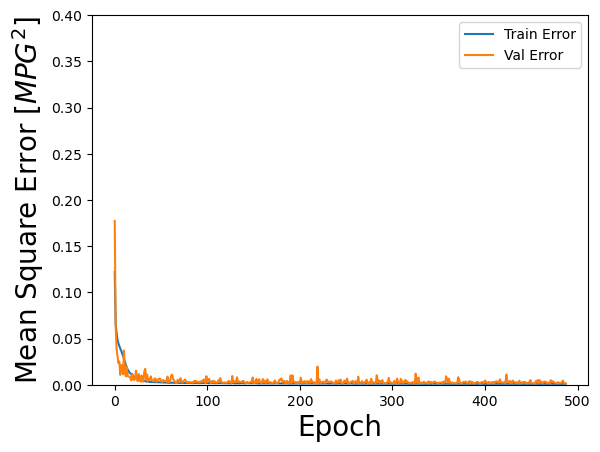

In [36]:
Y_test_scal = scaler_Y.transform(Y_test.values.reshape(-1,1)).reshape(-1, 21)
MSE_R_scal = MSE(Y_test_scal, predict_test_scal)
MSE_R = MSE(Y_test.values, predict_test)
print(MSE_R_scal)
print(MSE_R)
plot_history(history)

### Step 17: Save the best model

In [37]:
# save the model
# ANN.save(r'data_analysis/saved_model/ANN.h5')
# pickle.dump(scaler_X, open('scaler_X.pkl','wb'))
# pickle.dump(scaler_Y, open('scaler_Y.pkl','wb'))

# for i in range(len(predict_test)):
#     get_plot(Y_test.iloc[i, :], predict_test[i], i)

### Step 18: plot the relationships between predicted and experimental data(need further modification/need other data visualisation method)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


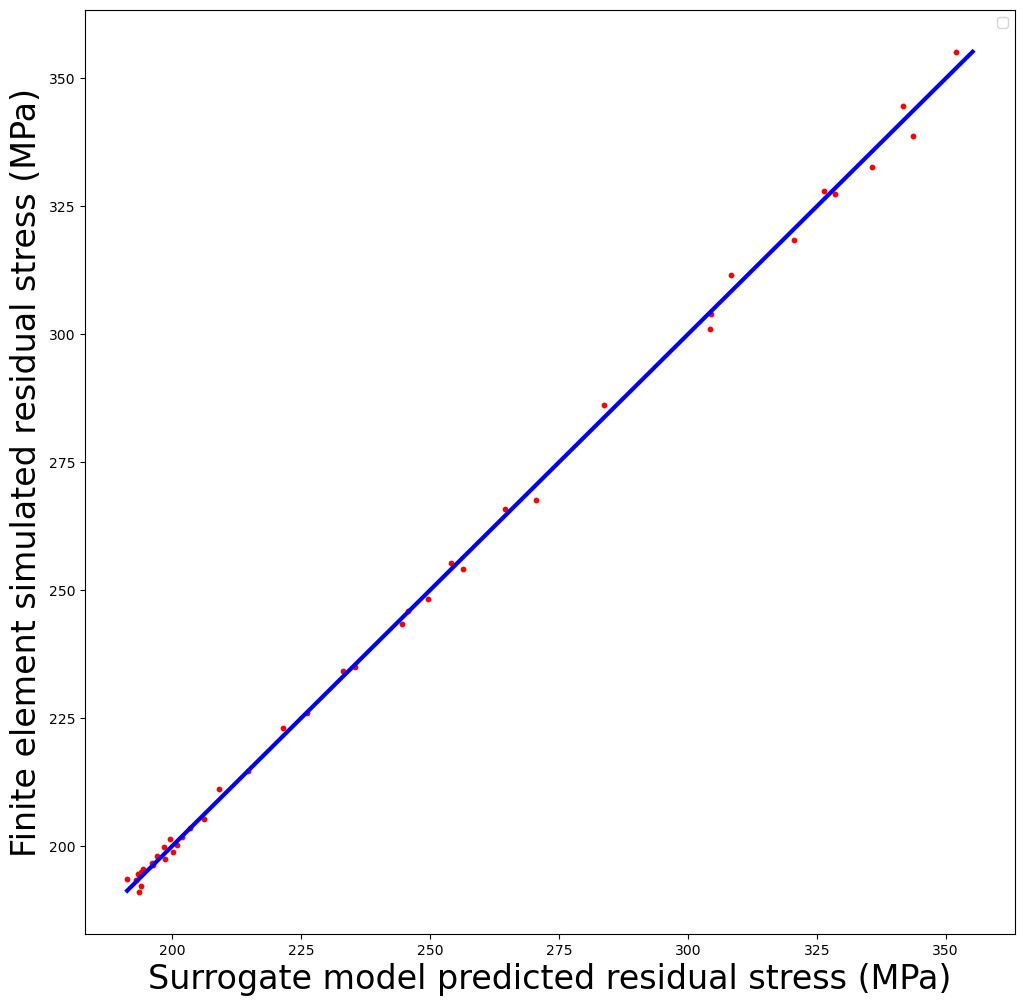

In [38]:
pred_results = []
sim_results = []
for i in range(len(predict_test)):
    for j in range(len(predict_test[0])):
        sim_results.append(Y_test.iloc[i, j])
        pred_results.append(predict_test[i][j])

max_results = max(max(pred_results,sim_results))
min_results = min(min(pred_results,sim_results))
fig,ax = plt.subplots(figsize=(12,12))
ax.plot([min_results, max_results], [min_results, max_results],'b', linewidth=3)
ax.scatter(pred_results, sim_results,s=10, c='r')
ax.set_xlabel("Surrogate model predicted residual stress (MPa)", fontsize=24)
ax.set_ylabel("Finite element simulated residual stress (MPa)", fontsize=24)
plt.legend()
plt.show()